In [1]:
import numpy as np
from scipy.linalg import expm
from tqdm.auto import trange, tqdm

/Users/visanim/work/random-markov-field/metabolite_inference/model_validation/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def create_rate_matrix(alpha: float) -> np.ndarray:
    if alpha > 1 or alpha < 0:
        raise ValueError("alpha must be between 0 and 1.")

    return np.array([[-alpha, alpha], [1 - alpha, alpha - 1]])

In [3]:
def calculate_P_matrix(
    rate_matrix: np.ndarray,
    log_nu: float,
    branch_length: float,
) -> np.ndarray:
    return expm(rate_matrix * branch_length * np.exp(log_nu))

In [4]:
# Function to simulate data
def simulate_data(alpha: float, log_nu: float, num_leaves: int, branch_length):
    root_state = np.random.choice([0, 1], p=[1 - alpha, alpha])
    P = calculate_P_matrix(create_rate_matrix(alpha), log_nu, branch_length)
    leaves = np.random.choice([0, 1], size=num_leaves, p=P[root_state])
    return root_state, leaves

In [5]:
# Likelihood function
def log_likelihood(
    alpha: float,
    root_state: int,
    leaves: np.ndarray,
    log_nu: float,
    branch_length: float,
):
    if alpha <= 0 or alpha >= 1:
        return -np.inf
    P = calculate_P_matrix(create_rate_matrix(alpha), log_nu, branch_length)
    p_root_to_leaves = P[root_state, leaves]
    return np.sum(np.log(p_root_to_leaves))

In [6]:
# MCMC to infer alpha with adaptive step size
def mcmc_infer_alpha(
    root_state,
    leaves,
    log_nu,
    branch_length,
    num_samples=10000,
    target_acceptance=0.4,
    adapt_interval=100,
):
    branch_length = 1 / len(leaves)
    alpha = np.random.uniform(0.0001, 0.999999)  # Initial alpha
    samples = []
    log_prob = log_likelihood(alpha, root_state, leaves, log_nu, branch_length)
    step_size = 0.5
    acceptances = 0

    for i in trange(num_samples, leave=False):
        new_alpha = alpha + np.random.uniform(-step_size, step_size)
        if new_alpha < 0:
            new_alpha = np.abs(new_alpha)
        if new_alpha > 1:
            new_alpha = 2 - new_alpha

        new_log_prob = log_likelihood(
            new_alpha, root_state, leaves, log_nu, branch_length
        )

        if np.log(np.random.rand()) < new_log_prob - log_prob:
            alpha, log_prob = new_alpha, new_log_prob
            acceptances += 1

        samples.append(alpha)

        # Adjust step size every adapt_interval steps
        # if (i + 1) % adapt_interval == 0:
        # acceptance_rate = acceptances / adapt_interval
        # if acceptance_rate < target_acceptance:
        # step_size *= 0.9
        # else:
        # step_size *= 1.1
        # acceptances = 0
    # print("Average acceptance: ", acceptances / num_samples)
    return np.array(samples)

In [7]:
# MCMC to infer alpha with adaptive step size
def mcmc_infer_log_nu(
    root_state,
    leaves,
    alpha,
    branch_length,
    num_samples=10000,
    target_acceptance=0.4,
    adapt_interval=100,
):
    branch_length = 1 / len(leaves)

    # log nu comes from a normal distribution
    log_nu = np.random.normal(loc=0.5, scale=2)  # Initial log_nu
    samples = []
    log_prob = log_likelihood(alpha, root_state, leaves, log_nu, branch_length)
    step_size = 0.5
    acceptances = 0

    for i in trange(num_samples, leave=False):
        new_log_nu = np.random.normal(loc=0.5, scale=2)

        new_log_prob = log_likelihood(
            alpha, root_state, leaves, new_log_nu, branch_length
        )

        if np.log(np.random.rand()) < new_log_prob - log_prob:
            log_nu, log_prob = new_log_nu, new_log_prob
            acceptances += 1

        samples.append(log_nu)

    return np.array(samples)

In [8]:
# Simulate data and run MCMC
true_alpha = 0.6
num_leaves = 60
true_log_nu = 0.5  # + np.log(1000 / 60)
branch_length = 1 / num_leaves
root_state, leaves = simulate_data(true_alpha, true_log_nu, num_leaves, branch_length)

samples = mcmc_infer_log_nu(
    root_state, leaves, true_alpha, branch_length, num_samples=20000
)

In [9]:
print(sum(leaves) / len(leaves), "are 1.")

0.03333333333333333 are 1.


In [10]:
calculate_P_matrix(
    create_rate_matrix(true_alpha), log_nu=true_log_nu, branch_length=1 / num_leaves
)

array([[0.98373725, 0.01626275],
       [0.01084183, 0.98915817]])

In [11]:
print("Mean alpha : ", np.mean(samples[-1000:]))

Mean alpha :  1.0037284100868427


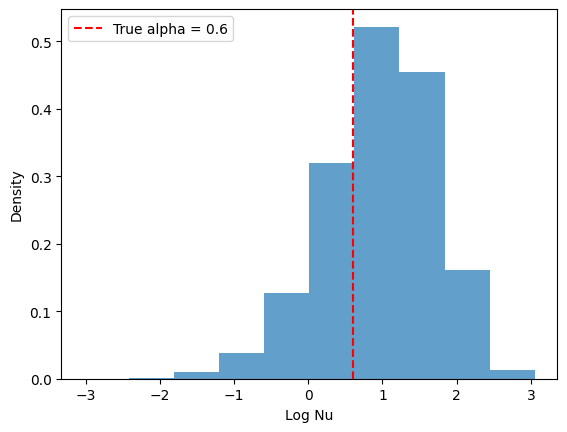

In [12]:
import matplotlib.pyplot as plt

# Plot results
plt.hist(samples, density=True, alpha=0.7)
plt.axvline(
    true_alpha,
    color="r",
    linestyle="dashed",
    label=f"True alpha = {true_alpha}",
)
plt.xlabel("Log Nu")
plt.ylabel("Density")
plt.legend()
plt.show()

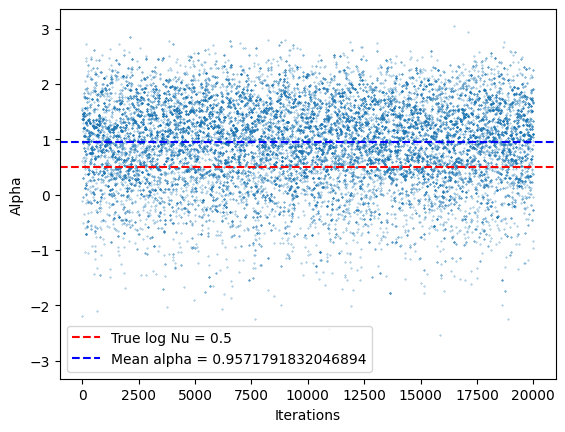

In [13]:
plt.scatter(x=range(len(samples)), y=samples, s=0.1, alpha=0.7)
plt.axhline(
    true_log_nu, color="r", linestyle="dashed", label=f"True log Nu = {true_log_nu}"
)
plt.axhline(
    np.mean(samples),
    color="b",
    linestyle="dashed",
    label=f"Mean alpha = {np.mean(samples)}",
)
plt.ylabel("Alpha")
plt.xlabel("Iterations")
plt.legend()
plt.show()

In [14]:
# simulate many times with same prior values
# infer
ls = []
root_states = []
number_of_ones = []

# Simulate data and run MCMC
for _ in trange(139):
    root_state, leaves = simulate_data(
        true_alpha, true_log_nu, num_leaves, branch_length
    )
    number_of_ones.append(sum(leaves))
    root_states.append(root_state)

    samples = mcmc_infer_log_nu(
        root_state, leaves, true_alpha, branch_length, num_samples=20000
    )

    ls.append(sum(samples < true_log_nu) / len(samples))

100%|██████████| 139/139 [00:41<00:00,  3.35it/s]


(-0.1, 1.1)

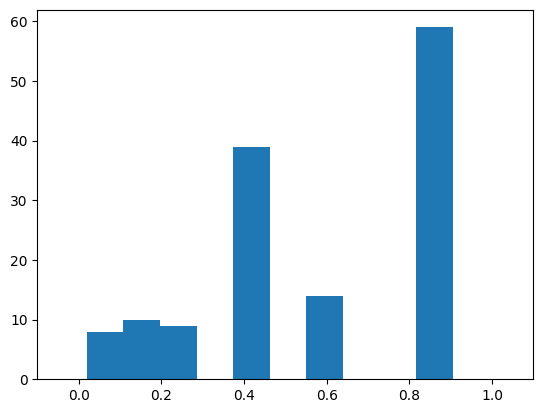

In [15]:
plt.hist(ls)
plt.xlim(-0.1, 1.1)

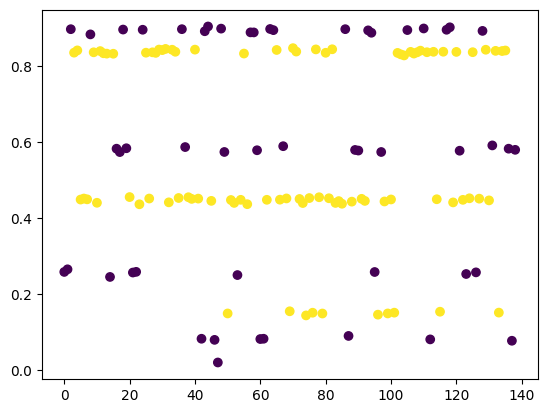

In [16]:
plt.scatter(x=range(len(ls)), y=ls, c=root_states)

In [17]:
np.mean(root_states)

np.float64(0.6330935251798561)

In [18]:
calculate_P_matrix(
    create_rate_matrix(true_alpha), true_log_nu, branch_length
) * num_leaves

array([[59.02423501,  0.97576499],
       [ 0.65051   , 59.34949   ]])

In [19]:
import pandas as pd

z_state = pd.read_csv("./single_root/acol_simulated_Z_species.txt", sep="\t")
y_state = pd.read_csv("./single_root/acol_simulated_Y.txt", sep="\t")

In [20]:
ls = []
log_nu = 0.5
branch_length = 1 / y_state.species.unique().shape[0]
true_alpha = 0.6

for i, row in tqdm(z_state.iterrows(), total=z_state.shape[0]):
    root_state = row["Z_state"]
    leaves = y_state[y_state["molecules"] == row["molecules"]]["Y_state"].values
    samples = mcmc_infer_alpha(
        root_state, leaves, log_nu, branch_length, num_samples=20000
    )
    ls.append(sum(samples < true_alpha) / len(samples))

100%|██████████| 139/139 [00:43<00:00,  3.22it/s]


(array([ 3.,  1.,  9., 43., 30.,  0., 23., 21.,  8.,  1.]),
 array([0.1213 , 0.20726, 0.29322, 0.37918, 0.46514, 0.5511 , 0.63706,
        0.72302, 0.80898, 0.89494, 0.9809 ]),
 <BarContainer object of 10 artists>)

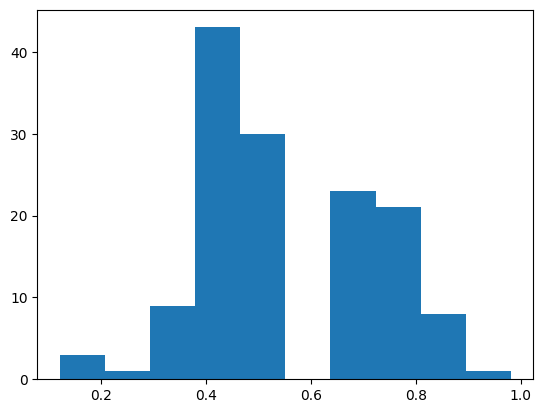

In [21]:
plt.hist(ls)

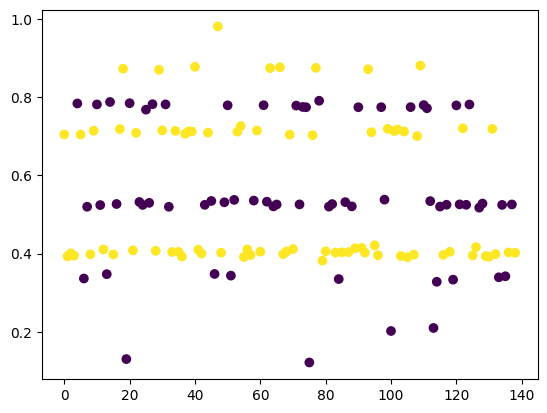

In [22]:
plt.scatter(x=range(len(ls)), y=ls, c=z_state["Z_state"])